In [15]:
import argparse
import configparser
import pandas as pd
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from scipy import stats as sts
import warnings
from model.DataModel import Data
#from model.BayesModel import GaussianProcessModel
warnings.simplefilter(action="ignore", category=FutureWarning)

In [12]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)
parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str)
args = parser.parse_args(args=['--dummy'])

config = configparser.ConfigParser()
config.read(args.config_file)
args.s3_bucket = config.get('default', 's3_bucket')
args.s3_prefix = config.get('default', 's3_prefix')

In [3]:
data = Data(args.s3_bucket, args.s3_prefix, args.last_n_days)
data.get_raw_generator()
data.preprocessing()

In [ ]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

sp_model = BaseLineModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)
y=sp_model.y
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean)/y_std
X=sp_model.t[:, None]/100

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=σ)

    trace = pm.sample(1000, cores=1)

In [27]:
X_new = np.linspace(-1, 10, 200)[:, None]

# add the GP conditional to the model, given the new X values
#with model:
#    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(trace, var_names=['f_pred'], samples=1000)

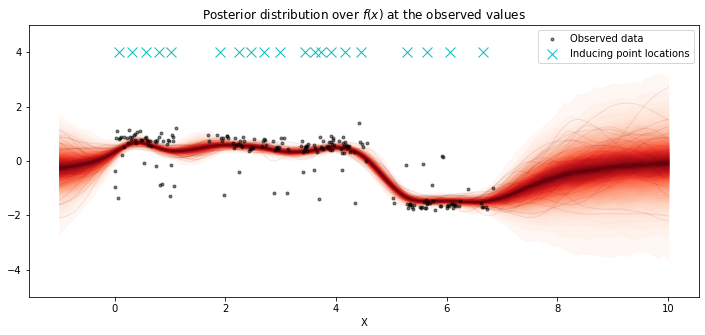

In [31]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# plot the data and the true latent function
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.plot(Xu, 4 * np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X")
plt.ylim([-5, 5])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

sp_model = BaseLineModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)
y=sp_model.y
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean)/y_std
X=sp_model.t[:, None]/100

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    ν = pm.Gamma("ν", alpha=2, beta=1)
    tp = pm.gp.TP(cov_func=cov, nu=ν)
    f = tp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν2 = pm.Gamma("ν2", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν2, observed=y)

    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)


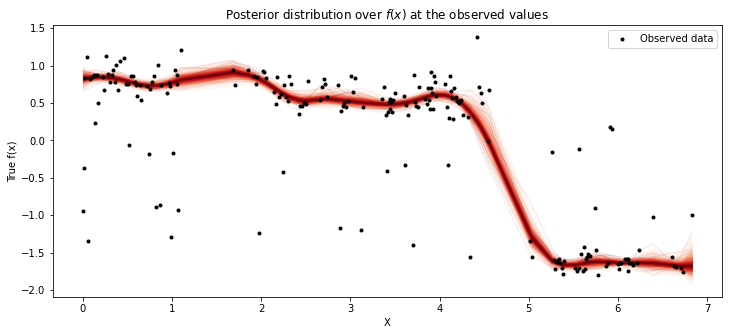

In [34]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

sp_model = BaseLineModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)
y=sp_model.y
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean)/y_std
X=sp_model.t[:, None]/100

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)
    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

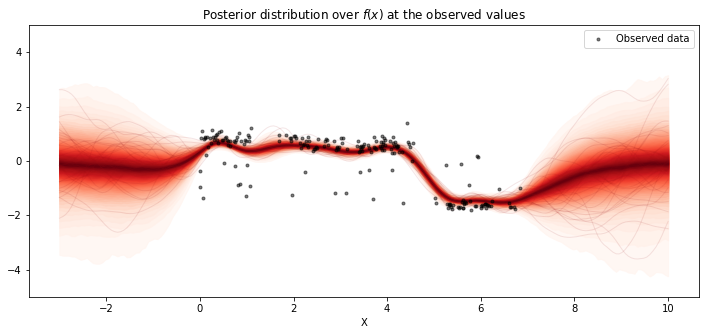

In [42]:
# new values from x=0 to x=20
X_new = np.linspace(-3, 10, 200)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(trace, var_names=['f_pred'], samples=2000)
    
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# plot the data and the true latent function
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylim([-5, 5])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

* Latent much slower than marginal while performances are similar (70s vs 1600s)
* No TP implementation in marginal
* Should not replace gp maringal with non-normal
* Marginal seems being not robust
* Sparse Approx similar to marginal
* scale of x matters, better bounded by 10